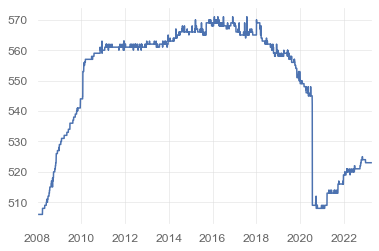

In [243]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import datetime

universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['adj_close'].unstack().reindex_like(P).pct_change()
income_statement = pd.read_parquet('data/US/income_statement.pq')

In [2]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).astype(float)
ltdebt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill().astype(float)
stdebt = balance_sheet['shortTermDebt'].unstack().reindex_like(P).ffill().astype(float)
cash_equiv = balance_sheet['cashAndEquivalents'].unstack().reindex_like(P).ffill().astype(float)

EV = mkt_cap + (ltdebt+stdebt)  - cash_equiv.fillna(0)
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)

EM = EV / ebitda

In [3]:
ebit = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalCurrentAssets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)

roic = ebit/(totalAssets - totalCurrentAssets)

In [4]:
ltDebt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill().astype(float)
stDebt = balance_sheet['shortTermDebt'].unstack().reindex_like(P).ffill().astype(float)
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
debt_assets = ((stDebt+ltDebt)/ totalAssets).reindex_like(P).ffill().astype(float)


In [5]:
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalLiabilities = balance_sheet['totalLiab'].unstack().reindex_like(P).ffill().astype(float)
book_value = totalAssets - totalLiabilities

shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)

book_value_share = book_value/ shares
adj_close = market_data['close'].unstack().reindex_like(P).astype(float)
PB_ratio = adj_close/book_value_share

<Axes: >

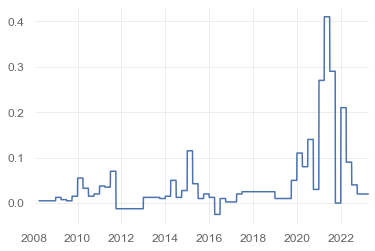

In [100]:
earnings = pd.read_parquet('data/US/earnings.pq')
(earnings['epsActual']- earnings['epsEstimate']).unstack().reindex_like(P).ffill()['AAPL'].plot()

In [47]:
earnings.index=  pd.MultiIndex.from_arrays([pd.to_datetime(earnings.index.get_level_values(0)), earnings.index.get_level_values(1)])

In [219]:
div = pd.read_parquet('data/US/dividends.pq')
div = div['unadjustedValue'].unstack()
div.index = pd.to_datetime(div.index)
div = div.reindex_like(P).ffill()


In [204]:
eps = (earnings['epsActual'] - earnings['epsEstimate']).unstack()
# eps = eps.reindex_like(P).ffill()

In [215]:
eps['META'].ffill().corr(R['META'].shift())

0.05548036468229811

In [244]:
eps = (earnings['epsActual'] - earnings['epsEstimate']).unstack().reindex_like(P).ffill()
alpha = eps[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

C:\Users\marti\AppData\Local\Temp\ipykernel_30912\98622094.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(252).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
C:\Users\marti\AppData\Local\Temp\ipykernel_30912\98622094.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe      3.404
Turnover    0.144
biais       2.234
dtype: float64

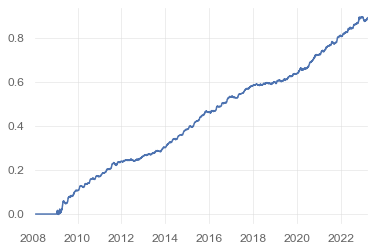

In [245]:
signal = alpha[P]
signal = signal[P].rolling(252).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)

# signal[signal.abs()<0.25] = None

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)


PNL = (signal[P].shift()*R).sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(3)

<Axes: >

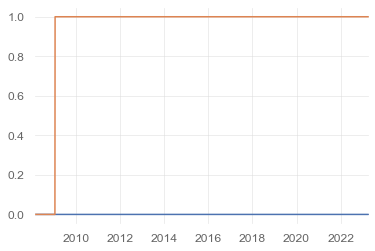

In [179]:
signal.sum(1).plot()
signal.abs().sum(1).plot()

<Axes: >

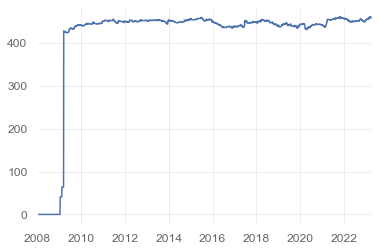

In [246]:
signal.count(1).plot()

Sharpe      3.426
Turnover    0.159
biais       2.445
dtype: float64

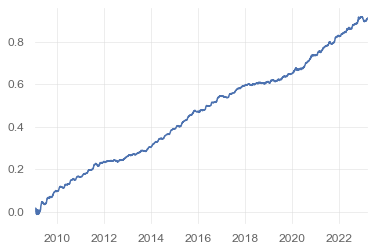

In [201]:
PNL = (signal[P].shift()*R).sum(1).loc['2009':]
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(3)

In [180]:
import quantstats as qs
sp500 = qs.utils.download_returns('SPY')
qs.reports.html(PNL,sp500)

c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


In [225]:
div = pd.read_parquet('data/US/dividends.pq')
div = div['unadjustedValue'].unstack()
div.index = pd.to_datetime(div.index)
div = div.reindex_like(P).ffill().astype(float)

net_income = income_statement['netIncome'].unstack()
net_income = net_income.reindex_like(P).ffill().astype(float)

shares = balance_sheet['commonStockSharesOutstanding'].unstack()
shares = shares.reindex_like(P).ffill().astype(float)


eps = (net_income/shares) - div
eps

Ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABK,ABMD,...,XRX,XTO,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,0.960185,-4.272755,0.574595,0.337937,1.055544,0.743536,0.91877,NaN,NaN,NaN,...,-2.709906,NaN,-0.263665,NaN,0.540329,0.682492,NaN,1.038675,NaN,0.752691
2023-04-03,0.960185,-4.272755,0.574595,0.337937,1.055544,0.743536,0.91877,NaN,NaN,NaN,...,-2.709906,NaN,-0.263665,NaN,0.540329,0.682492,NaN,1.038675,NaN,0.752691
2023-04-04,0.960185,-4.272755,0.574595,0.337937,1.055544,0.743536,0.91877,NaN,NaN,NaN,...,-2.709906,NaN,-0.263665,NaN,0.540329,0.682492,NaN,1.038675,NaN,0.752691
2023-04-05,0.960185,-4.272755,0.574595,0.337937,1.055544,0.743536,0.91877,NaN,NaN,NaN,...,-2.709906,NaN,-0.263665,NaN,0.540329,0.682492,NaN,1.038675,NaN,0.752691


C:\Users\marti\AppData\Local\Temp\ipykernel_30912\2804078726.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(100).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
C:\Users\marti\AppData\Local\Temp\ipykernel_30912\2804078726.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe      1.515
Turnover    0.277
biais       1.022
dtype: float64

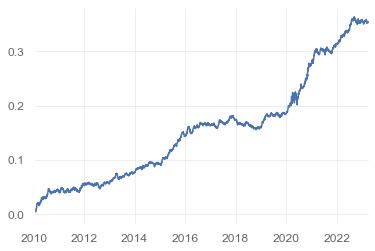

In [230]:
signal = eps[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rolling(100).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.1] = None

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)


PNL = (signal[P].shift()*R).sum(1).loc['2010':]
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(3)